<a href="https://colab.research.google.com/github/ViktorJOlah/Neuro_ANN/blob/main/microcircuit/L5_Rett.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this is for testing purposes, for getting the most out of GPU

import tensorflow as tf
tf.test.gpu_device_name()


# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os

import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 
"""

import tensorflow as tf
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="grpc://" + os.environ["COLAB_TPU_ADDR"])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
"""




from google.colab import drive
drive.mount('/content/drive')

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=6007a7f6b0afabd5bdd079bcf45d9788fbaf09bcd91b674d6bd203c536207858
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.2 GB  | Proc size: 1.0 GB
GPU RAM Free: 14852MB | Used: 227MB | Util   2% | Total 15079MB
Mounted at /content/drive


In [ ]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LocallyConnected1D

import tensorflow as tf

import random

import matplotlib.pyplot as plt
import gc
from collections import deque


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [ ]:
#we need to create the dataset as for ANN fitting, to initialize the ANNs with random voltages and inputs

params = {
    "batch_size": 64,
    "epochs": 1,
    "lr": 0.0010000,
    "time_steps": 64,
    "rec_length": 10000
}


TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
steps_per_epoch = 2000

def time_it(func):
    def wrapper(*arg, **kw):
        t1 = time.time()
        res = func(*arg, **kw)
        t2 = time.time()
        print(t2 - t1)
        return (t2 - t1), res, func.__name__
    return wrapper


def serve_CNN_LSTM(x):
    return CNN_LSTM(x, training=False)



def trim_dataset(mat,batch_size):

    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

def build_timeseries(mat, y_col_index):

    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,1))
    print("dim_0",dim_0)
    counter = 0
    for i in range(dim_0):
        #get rid of contaminated results (ie: end of trace - beginning of trace samples)
        x[counter] = mat[counter:TIME_STEPS+counter]
        y[counter] = mat[TIME_STEPS+counter, y_col_index:1]
        counter += 1
            
    print("length of time-series i/o",x.shape,y.shape)
    return x[:counter], y[:counter]



In [ ]:
data = pd.read_csv('/content/drive/My Drive/DNN/L5_plasticity/processed_L5_final_new_1ms_below10Hz_50000.txt', sep=" ", header=None, dtype='float16', nrows=50000)

In [ ]:

def create_dataset(data1):

  df_train, df_test = train_test_split(data1, train_size=0.9, test_size=0.1, shuffle=False)
  print(f"Train size is: {len(df_train)}  -- Test size is: {len(df_test)}")



  x_train = np.asarray(df_train, dtype='float16')
  x_test = np.asarray(df_test, dtype='float16')

  x_t, y_t = build_timeseries(x_train, 0)
  
  del x_train
  del df_train


  x_t = trim_dataset(x_t, BATCH_SIZE)
  y_t = trim_dataset(y_t, BATCH_SIZE)
  print("Batch trimmed size",x_t.shape, y_t.shape)

  #this is a must have, otherwise the model thinks that the 3 labels are sequential in time
  y_t = np.reshape(y_t, [y_t.shape[0], 1, 1])

  x_t = np.array(x_t, dtype='float16')
  y_t = np.array(y_t, dtype='float16')

  x_temp, y_temp = build_timeseries(x_test, 0)

  y_temp = np.reshape(y_temp, [y_temp.shape[0], 1, 1])

  x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
  y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

  print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

  x_val = np.array(x_val, dtype='float16')
  y_val = np.array(y_val, dtype='float16')

  del y_temp
  del x_test
  del df_test

  return x_t, y_t, x_val, y_val



In [ ]:


from tensorflow.keras import regularizers
def create_model_CNN_LSTM2():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(512, 1, activation='relu', kernel_initializer="he_uniform", padding="causal", kernel_regularizer=regularizers.l1(1e-5), input_shape=(TIME_STEPS, x_t.shape[2])),
        tf.keras.layers.Conv1D(256, 5, activation='relu', kernel_initializer="he_uniform", padding="causal"),
        tf.keras.layers.Conv1D(128, 1, activation='tanh', kernel_initializer='glorot_uniform', padding="causal"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.RepeatVector(5),
        tf.keras.layers.LSTM(128, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True),
        tf.keras.layers.LSTM(128, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True),
        tf.keras.layers.LSTM(128, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(100, activation='selu', kernel_initializer="lecun_uniform"),
        tf.keras.layers.Dense(1)])
    model.compile(loss=['mae'], optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001))
    return model

   

In [ ]:
#created dataaset and load ANN

x_t, y_t, x_val, y_val = create_dataset(data[:])

CNN_LSTM = create_model_CNN_LSTM2()
CNN_LSTM.load_weights("/content/drive/My Drive/DNN/L5_plasticity/weights.best-300-0.000443-0.000364.h5")

Train size is: 45000  -- Test size is: 5000
dim_0 44936
length of time-series i/o (44936, 64, 201) (44936, 1)
Batch trimmed size (44928, 64, 201) (44928, 1)
dim_0 4936
length of time-series i/o (4936, 64, 201) (4936, 1)
Test size (2464, 64, 201) (2464, 1, 1) (2464, 64, 201) (2464, 1, 1)


In [ ]:
#define connectivity matrix with unidirectional and bidirectional connectivity set differently
#connectivity: https://academic.oup.com/cercor/article/25/10/3561/388287

def get_conn_matrix(arg1):

    desired_uni_conn = arg1
    desired_rec_conn = arg1*0.5

    import random
    random.seed(a=1, version=2)

    connectivity_matrix = [[0 for k in range(150)] for i in range(150)]
    connectivity_matrix = np.asarray(connectivity_matrix)

    all_possible_uni_conn = 149*150
    all_possible_rec_conn = 11026

    number_of_desired_uni = all_possible_uni_conn * desired_uni_conn
    number_of_desired_rec = all_possible_rec_conn * desired_rec_conn
    uni_counter1 = 0
    while uni_counter1 < number_of_desired_uni:
        row = int(random.random()*150)
        col = int(random.random()*150)
        if connectivity_matrix[row][col] == 0 and connectivity_matrix[col][row] == 0:
            connectivity_matrix[row][col] = 1
            uni_counter1 += 1
    
    sanity_check = 0
    for i in range(150):
        sanity_check += np.sum(connectivity_matrix[i])

    rec_counter1 = 0
    while rec_counter1 < number_of_desired_rec:
        row = int(random.random()*150)
        col = int(random.random()*150)
        if connectivity_matrix[row][col] == 0 and connectivity_matrix[col][row] == 0:
            connectivity_matrix[row][col] = 1
            connectivity_matrix[col][row] = 1
            rec_counter1 += 1



    uni_counter = 0
    rec_counter = 0
    for i in range(150):
        for j in range(150):
            if connectivity_matrix[i][j] + connectivity_matrix[j][i] == 1:
                uni_counter += 1
            if connectivity_matrix[i][j] == 1 and connectivity_matrix[j][i] == 1:
                rec_counter += 1
            

    print(f"unidirectional connectivity: {uni_counter/2/(149*150)}, reciprocal connectivity: {rec_counter/2/(11026)}")

    return connectivity_matrix



In [ ]:
#definition of L5 plasticity mechanisms
#https://www.frontiersin.org/articles/10.3389/fnsyn.2019.00029/full#h6

def calc_efficacy(spike_times):
    U = 0.38    # 0.01-1.0, delta: 0.05 --> 20
    D = 365.6   # 20-400, delta: 20     --> 20
    F = 25.71   # 10-50, delta: 2        --> 20      --> 8000 simulations

    A = 1
    u1 = U
    R1 = 1

    Am = 0.0001
    un = 0
    Rn = 0
    Rm = 0


    for place, val in enumerate(spike_times):
        if place == 0:
            Am = A*u1*R1
            un = u1
            Rn = R1
            #print(Am/U)
        else:
            um = U + un*(1-U)*np.exp(-((val-spike_times[place-1])/F))
            Rm = 1 + (Rn-Rn*un-1)*np.exp(-((val-spike_times[place-1])/D))
            Am = A*um*Rm
            
            un = um
            Rn = Rm
            
            #print(Am/U)
    return Am/U


In [ ]:
#this is the main function for running the L5 microcircuit, with the previously established connectivity matrix and the set plasticity mechanism

@time_it
def run_circuit(conn_mat, eiscale):
    return_spikes = []
    updated_list = []
    out = []
    spike_matrix = [[]for i in range(150)]

    eiscale_vec = []
    for i in range(201):
        if i < 151:
            eiscale_vec.append(eiscale)
        else:
            eiscale_vec.append(0.5)

    for i in range(150):
        starting_point = 300+i*200
        updated_list.append(deque(x_t[starting_point], maxlen=64))

    for time1 in range(300):
        scaling = 1.0005191447815092-0.00015243712218148255*(0.9947875832020883**time1)
        new_mp = np.mean(serve_CNN_LSTM(np.asarray(updated_list).astype('float32')), axis=1)*scaling

        out.append(new_mp)

        spike_flag = []

        for i in range(150):
            counter = 300+i*200+time1+1
            #new_input = x_t[counter][-1] * eiscale
            new_input = np.multiply(x_t[counter][-1], eiscale_vec)
            new_input[0] = new_mp[i]
            if time1 == 100:            #this is the stimuli
                new_input[1] = 0.05
            updated_list[i].append(new_input)
            if new_mp[i] > 0.3 and new_mp[i] < updated_list[i][-2][0]:
                spike_flag.append(1)
                spike_matrix[i].append(i)
            else:
                spike_flag.append(0)

        syn_scales = []
        for i in range(150):
            #print(calc_efficacy(spike_matrix[i]))
            syn_scales.append(calc_efficacy(spike_matrix[i]))
            

        for i in range(150):
            for j in range(150):
                #print(len(spike_flag))
                #syn_scaling = 0.605

                syn_scaling = eiscale*calc_efficacy(spike_matrix[j])

                if conn_mat[i][j] == 1 and spike_flag[j] == 1:
                    updated_list[i][-1][1] = 0.0036*syn_scaling
                    updated_list[i][-1][2] = 0.0036*syn_scaling
                    updated_list[i][-1][3] = 0.0036*syn_scaling
                    updated_list[i][-1][4] = 0.0036*syn_scaling
                    updated_list[i][-1][5] = 0.0036*syn_scaling
                if conn_mat[i][j] == 1 and conn_mat[j][i] == 1 and spike_flag[j] == 1:
                    updated_list[i][-1][1] = 0.0054*syn_scaling
                    updated_list[i][-1][2] = 0.0054*syn_scaling
                    updated_list[i][-1][3] = 0.0054*syn_scaling
                    updated_list[i][-1][4] = 0.0054*syn_scaling
                    updated_list[i][-1][5] = 0.0054*syn_scaling

    spikes = [[] for i in range(150)]
    
    spike_counter = 0
    for i in range(150):
        out1 = [out[k][i][0] for k in range(300)]
        vm_out = np.transpose(out1)

        out_spikes = []

        for index, val in enumerate(vm_out):
            if index < 299:
                if val > 0.3 and val > vm_out[index-1] and val > vm_out[index+1]:
                    out_spikes.append(index)
                    return_spikes.append(index)
        spikes[i] = out_spikes
        spike_counter += len(out_spikes)
        """
        if i==0:
            plt.plot(out1[:250])
            plt.show()
            representative_plot = out1[:250]
    """
    lineSize = [1 for k in range(150)]
    plt.eventplot(spikes, linelengths = lineSize)
    plt.show()
    
    return return_spikes



unidirectional connectivity: 0.11910514541387024, reciprocal connectivity: 0.0607201160892436


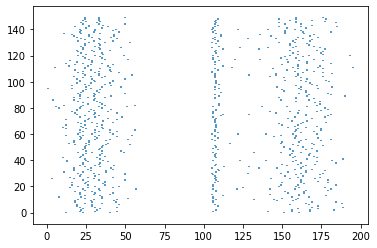

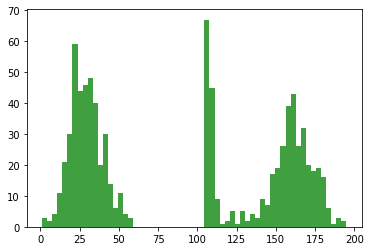

In [ ]:
connectivity_matrix = get_conn_matrix(0.12)
return_spikes = run_circuit(connectivity_matrix, 0.5)

n, bins, patches = plt.hist(return_spikes, 60, facecolor='green', alpha=0.75)
plt.show()

np.savetxt("/content/drive/My Drive/DNN/L5_plasticity/raster.txt", return_spikes)
np.savetxt("/content/drive/My Drive/DNN/L5_plasticity/hist.txt", np.transpose(np.vstack((bins[:-1], n))))


unidirectional connectivity: 0.0497986577181208, reciprocal connectivity: 0.025122437874115725


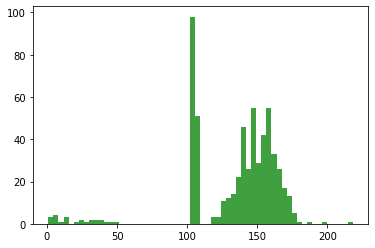

In [ ]:
connectivity_matrix = get_conn_matrix(0.05)
return_spikes = run_circuit(connectivity_matrix, 0.5)

n, bins, patches = plt.hist(return_spikes, 60, facecolor='green', alpha=0.75)
plt.show()